In [1]:
%matplotlib inline 
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import glob
import random
import re
import time
import math
import os
import sys
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
import importlib
sys.path.append('..')
import Shared # Shared.py holds functions common to all notebooks
importlib.reload(Shared) # In case you make changes to the Shared.py file and don't want to restart the nb kernel 

<module 'Shared' from '/home/eduardo/Desktop/Link to dynamic-projections/Models/Shared.py'>

In [3]:
nb_name = 'fashion-C2VAE_32c_64c_128c_2f_ep40'  # Couldn't figure out how to get this automatically

In [4]:
X, info_df, n_revisions, CATEGORIES = Shared.load_drawings('../../Datasets/fashion/')
# Flatten Nx28x28 -> Nx784x1
N = len(X)
# np.reshape(X, (len(X), 1, 784))
# X_flat = np.reshape(np.ravel(X), (N, -1))
len(X), len(info_df), n_revisions, CATEGORIES

(10000,
 10000,
 10,
 {0: 'ankleboot',
  1: 'bag',
  2: 'coat',
  3: 'dress',
  4: 'pullover',
  5: 'sandal',
  6: 'shirt',
  7: 'sneaker',
  8: 'trouser',
  9: 'tshirt'})

In [5]:
info_df.head()

,X_index,drawing_cat_id,drawing_cat_str,drawing_id,t
0,0,9,tshirt,687,3
1,1,0,ankleboot,596,0
2,2,2,coat,589,8
3,3,5,sandal,399,1
4,4,2,coat,12,3


In [6]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Lambda
from keras.models import Model
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.objectives import categorical_crossentropy
from keras.losses import mse, binary_crossentropy

from keras import backend as K

In [7]:
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """
    z_mean, z_lvar = args
    
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    
    # By default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    
    return z_mean + K.exp(0.5*z_lvar)*epsilon

# Encoder
inputs = Input(shape=(28, 28, 1), name='encoder_input')
x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Flatten()(x)
z_mean = Dense(2, name='z_mean')(x)
z_lvar = Dense(2, name='z_lvar')(x)
l_code = Lambda(sampling, name='l_code')([z_mean, z_lvar])

encoder = Model(inputs, [z_mean, z_lvar, l_code], name='encoder')

# Decoder
encoded = Input(shape=(2,), name='z_sampled')
x = Dense(6272)(encoded)
x = Reshape((7, 7, 128))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
output = Conv2D(1, (3, 3), activation='relu', padding='same')(x)

decoder = Model(encoded, output, name='decoder')

# VAE
va_out = decoder(encoder(inputs)[2])
vae = Model(inputs, va_out, name='vae')

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
encoder.summary()
decoder.summary()
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         encoder_input[0][0]              
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 14, 14, 32)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   18496       max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
max_poolin

In [9]:
# input_img = Input(shape=(28, 28, 1))
# # input_img = Input(shape=(28, 28, 1))
# x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
# x = MaxPooling2D((2, 2), padding='same')(x)
# x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
# x = MaxPooling2D((2, 2), padding='same')(x)
# x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
# # encoded = Conv2D(2, (2, 2), activation='relu', padding='same', strides=(1,4))(x)
# x = Flatten()(x)
# encoded = Dense(2)(x)
# x = Dense(1568)(encoded)
# x = Reshape((7,7,32))(x)
# x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
# x = UpSampling2D((2,2))(x)
# x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
# x = UpSampling2D((2,2))(x)
# x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
# decoded = Conv2D(1, (3, 3), activation='relu', padding='same')(x)

# ae = Model(input_img, decoded)
# encoder = Model(input_img, encoded)
# ae.summary()

In [10]:
# Build VAE loss function. It takes into account the variance layer outputs too.
reconstruction_loss = mse(K.flatten(inputs), K.flatten(va_out))
reconstruction_loss *= 784
kl_loss = 1 + z_lvar - K.square(z_mean) - K.exp(z_lvar)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

In [11]:
# Compile and summary
vae.compile(optimizer='adam')

In [12]:
(x_train, x_test) = train_test_split(np.array(X).reshape([-1, 28, 28, 1]), test_size=0.1, shuffle=True, random_state=0)

In [13]:
x_train.shape, x_test.shape, vae.input_shape, vae.output_shape

((9000, 28, 28, 1), (1000, 28, 28, 1), (None, 28, 28, 1), (None, 28, 28, 1))

In [14]:
# Train the VAE.
h = vae.fit(x_train, epochs=40, batch_size=32, validation_data=(x_test, None))

Instructions for updating:
Use tf.cast instead.
Train on 9000 samples, validate on 1000 samples
Epoch 1/40
9000/9000 [==============================] - 158s 18ms/step - loss: 70.4649 - val_loss: 57.1624
Epoch 2/40
9000/9000 [==============================] - 151s 17ms/step - loss: 56.1000 - val_loss: 55.5383
Epoch 3/40
9000/9000 [==============================] - 153s 17ms/step - loss: 55.2001 - val_loss: 54.7382
Epoch 4/40
9000/9000 [==============================] - 191s 21ms/step - loss: 54.7849 - val_loss: 54.5223
Epoch 5/40
9000/9000 [==============================] - 207s 23ms/step - loss: 54.3473 - val_loss: 53.7259
Epoch 6/40
9000/9000 [==============================] - 179s 20ms/step - loss: 54.0275 - val_loss: 53.3470
Epoch 7/40
9000/9000 [==============================] - 157s 17ms/step - loss: 53.6724 - val_loss: 53.7384
Epoch 8/40
9000/9000 [==============================] - 161s 18ms/step - loss: 53.5659 - val_loss: 53.6363
Epoch 9/40
9000/9000 [==========================

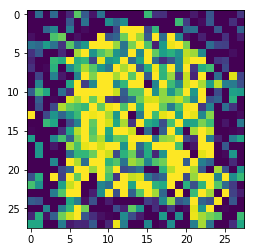

In [15]:
plt.imshow(x_test[0:1].reshape((28, 28)))

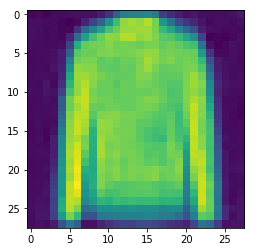

In [16]:
plt.imshow(vae.predict(x_test[0:1]).reshape((28, 28)))

In [17]:
# vae.save('../Models/{}.h5'.format(nb_name))

In [18]:
# from keras.models import load_model
# ae = load_model('../Models/{}.h5'.format(nb_name))


Text(0.5, 0.98, 'loss')

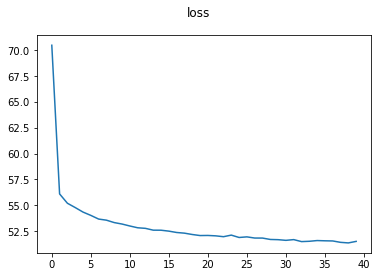

In [19]:
plt.figure()
plt.plot(vae.history.history['loss'])
plt.suptitle('loss')

In [20]:
#Shared.save_quickdraw_activations(ae, np.array(X).reshape([-1, 28, 28, 1]), info_df, n_revisions, nb_name)

In [21]:
# Collect all activations
layer_output = encoder.predict(np.array(X).reshape([-1, 28, 28, 1]))[0]

In [22]:
layer_output.shape

(10000, 2)

In [23]:
# Write activations to csv
header = ['id']
for t in range(n_revisions):
    for d in range(layer_output.shape[1]):
        header.append('t{}d{}'.format(t, d))

csv_out = []
gb = info_df.groupby(['drawing_cat_str', 'drawing_id'])
for index, df in gb:  # Iterave over all drawing sequences
    drawing_id = index[0] + '-' + str(index[1])
    item_row = [drawing_id]
    for index, _ in df.sort_values('t').iterrows():  # For all timesteps
        for d in range(layer_output.shape[1]):  # Add all dimensions
            item_row.append(layer_output[index][d])
    csv_out.append(item_row)

df_out = pd.DataFrame(csv_out, columns=header)
df_out.to_csv('../../Output/{}.csv'.format(nb_name), index=False)